# Task09 Boosting的思路与Adaboost算法

## 1 知识梳理

### 1.1 Boosting方法的基本思路
- 弱学习与强学习：
  - 弱学习：识别错误率小于1/2（即准确率仅比随机猜测略高的学习算法）
  - 强学习：识别准确率很高并能在多项式时间内完成的学习算法
- 一个概念是强可学习的充分必要条件是这个概念是弱可学习
- Boosting方法思路：通过反复学习，得到一系列弱分类器，然后通过一定的形式将这些弱分类器构建成一个强分类器

### 1.2 Adaboost算法

#### 1.2.1 Adaboost算法的基本原理
- 提高前一轮分类中分类错误的样本权重，降低分类正确的样本权重
- 采用加权多数表决的方式将弱分类器构建成强分类器
- 具体算法：
  1. 初始化数据分布：$\displaystyle D_{1}=\left(w_{11}, \cdots, w_{1 i}, \cdots, w_{1 N}\right), \quad w_{1 i}=\frac{1}{N}, \quad i=1,2, \cdots, N$，其目的是为了每个样本在基本分类器的学习中作用一样
  2. 对于$m=1,2,\cdots,M$，其中$M$表示基本分类器的个数  
  （1）使用具有$D_m$分布的训练数据集进行学习，得到基本分类器：$G_{m}(x): \mathcal{X} \rightarrow\{-1,+1\}$  
  （2）计算$G_m(x)$在训练集上的分类误差率：$\displaystyle e_m=\sum_{i=1}^{N} w_{m i} I\left(G_{m}\left(x_{i}\right) \neq y_{i}\right)$  
  （3）计算$G_m(x)$的系数：$\displaystyle \alpha_{m}=\frac{1}{2} \log \frac{1-e_{m}}{e_{m}}$，表示在强分类器的重要程度  
  （4）更新训练数据集的权重分布：$$
   \begin{array}{c}
   D_{m+1}=\left(w_{m+1,1}, \cdots, w_{m+1, i}, \cdots, w_{m+1, N}\right) \\
   \displaystyle w_{m+1, i}=\frac{w_{m i}}{Z_{m}} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right), \quad i=1,2, \cdots, N
   \end{array}$$
  3. 构建基本分类器的线性组合$\displaystyle f(x)=\sum_{m=1}^{M} \alpha_{m} G_{m}(x)$，即将$M$个基本分类器加权表决，得到最终的分类器$$\begin{aligned}
G(x) &=\operatorname{sign}(f(x)) \\
&=\operatorname{sign}\left(\sum_{m=1}^{M} \alpha_{m} G_{m}(x)\right)
\end{aligned}$$  
    **注：**所有的$\alpha_m$之和不为1

## 2 实战练习

### 2.1 使用自编码的Adaboost算法进行建模

In [1]:
import numpy as np

# 加载训练数据，数据集来自与教程的例题
X = np.arange(10)
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

In [2]:
class AdaBoost:
    def __init__(self, X, y, tol=0.05, max_iter=10):
        # 训练数据 实例
        self.X = X
        # 训练数据 标签
        self.y = y
        # 训练中止条件 right_rate>self.tol
        self.tol = tol
        # 最大迭代次数
        self.max_iter = max_iter
        # 初始化样本权重w
        self.w = np.full((X.shape[0]), 1 / X.shape[0])
        # 弱分类器
        self.G = []  

    def build_stump(self):
        """
        以带权重的分类误差最小为目标，选择最佳分类阈值
        best_stump['dim'] 合适的特征所在维度
        best_stump['thresh'] 合适特征的阈值
        """
        if len(self.X.shape) == 1:
            self.X = self.X.reshape(-1, 1)
        m, n = np.shape(self.X)
        # 分类误差
        e_min = np.inf
        # 小于分类阈值的样本属于的标签类别
        sign = None
        # 最优分类树桩
        best_stump = {}
        for i in range(n):
            # 求每一种特征的最大最小值
            range_min = self.X[:, i].min()  
            range_max = self.X[:, i].max()
            for thresh_val in np.arange(range_min, range_max, 0.5):
                for intq in ['lt', 'lf']:
                    predict_vals = self.base_estimator(self.X, i, thresh_val, intq)
                    err_arr = np.ones(m)
                    err_arr[predict_vals.T == self.y.T] = 0
                    weighted_error = np.dot(self.w, err_arr)
                    if weighted_error < e_min:
                        e_min = weighted_error
                        sign = predict_vals
                        best_stump['dim'] = i
                        best_stump['thresh'] = thresh_val
                        best_stump['intq'] = intq
        return best_stump, sign, e_min

    def updata_w(self, alpha, predict):
        """
        更新样本权重w
        """
        # 以下2行根据公式更新样本权重
        P = self.w * np.exp(-alpha * self.y * predict)
        self.w = P / P.sum()

    @staticmethod
    def base_estimator(X, dimen, threshVal, intq):
        """
        计算单个弱分类器预测输出
        """
        # 预测矩阵
        ret_array = np.ones(np.shape(X)[0])
        if intq == 'lt':
            if len(X.shape) == 1:
                ret_array[X >= threshVal] = -1.0
            else:
                ret_array[X[:, dimen] >= threshVal] = -1.0
        else:
            if len(X.shape) == 1:
                ret_array[X < threshVal] = -1.0
            else:
                ret_array[X[:, dimen] < threshVal] = -1.0
        return ret_array

    def fit(self):
        """
        对训练数据进行学习
        """
        G = 0
        for i in range(self.max_iter):
            # 获取当前迭代最佳分类阈值
            best_stump, sign, error = self.build_stump()  
            # 计算本轮弱分类器的系数
            alpha = 1 / 2 * np.log((1 - error) / error)  
            # 弱分类器权重
            best_stump['alpha'] = alpha
            # 保存弱分类器
            self.G.append(best_stump)
            # 以下3行计算当前总分类器（之前所有弱分类器加权和）分类效率
            G += alpha * sign
            y_predict = np.sign(G)
            error_rate = np.sum(np.abs(y_predict - self.y)) / 2 / self.y.shape[0]
            print("第%i次迭代" % (i+1))
            self.print_fun()
            
            if error_rate < self.tol:  
                # 满足中止条件 则跳出循环
                break
            else:
                # 若不满足，更新权重，继续迭代
                self.updata_w(alpha, y_predict)  

    def predict(self, X):
        """
        对新数据进行预测
        """
        m = np.shape(X)[0]
        G = np.zeros(m)
        for i in range(len(self.G)):
            stump = self.G[i]
            # 遍历每一个弱分类器，进行加权
            _G = self.base_estimator(X, stump['dim'], stump['thresh'], stump['intq'])
            alpha = stump['alpha']
            G += alpha * _G
        y_predict = np.sign(G)
        return y_predict.astype(int)

    def score(self, X, y):
        """对训练效果进行评价"""
        y_predict = self.predict(X)
        error_rate = np.sum(np.abs(y_predict - y)) / 2 / y.shape[0]
        return 1 - error_rate

    def print_fun(self):
        i = 1
        s = "f(x)="
        for stump in self.G:
            if i != 1:
                s += "+"
            s += "{}·G{}(x)".format(round(stump['alpha'], 4), i)
            i += 1
        print(s)

In [3]:
clf = AdaBoost(X, y, max_iter=10)
clf.fit()
y_predict = clf.predict(X)
score = clf.score(X, y)
print("\n原始输出:", y)
print("预测输出:", y_predict)
print("预测正确率：{:.2%}".format(score))

第1次迭代
f(x)=0.4236·G1(x)
第2次迭代
f(x)=0.4236·G1(x)+0.6496·G2(x)
第3次迭代
f(x)=0.4236·G1(x)+0.6496·G2(x)+0.752·G3(x)

原始输出: [ 1  1  1 -1 -1 -1  1  1  1 -1]
预测输出: [ 1  1  1 -1 -1 -1  1  1  1 -1]
预测正确率：100.00%


### 2.2 使用鸢尾花数据集对Adaboost建模

In [4]:
from sklearn import datasets
import pandas as pd 

iris = datasets.load_iris()
X = iris.data
y = iris.target
features = iris.feature_names
iris_data = pd.DataFrame(X,columns=features)
iris_data['target'] = y
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
# 数据预处理
# 仅仅考虑0，1类鸢尾花
iris_data = iris_data.loc[iris_data.target.isin([0, 2])]
y = iris_data['target'].values
X = iris_data[['sepal length (cm)','sepal width (cm)']].values

# 将分类标签变成二进制编码：
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
# 按8：2分割训练集和测试集
from sklearn.model_selection import train_test_split

# stratify参数代表了按照y的类别等比例抽样
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)  

In [7]:
# 使用单一决策树建模
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=1)
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train,tree_test))

Decision tree train/test accuracies 0.975/0.850


In [8]:
# 使用sklearn实现Adaboost(基分类器为决策树)
'''
AdaBoostClassifier相关参数：
base_estimator：基本分类器，默认为DecisionTreeClassifier(max_depth=1)
n_estimators：终止迭代的次数
learning_rate：学习率
algorithm：训练的相关算法，{'SAMME'，'SAMME.R'}，默认='SAMME.R'
random_state：随机种子
'''
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.900


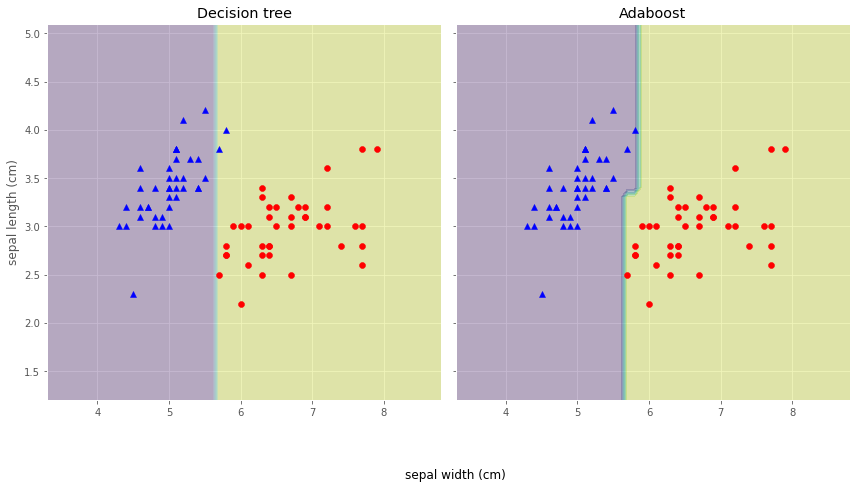

In [9]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# 画出单层决策树与Adaboost的决策边界：
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,sharex='col',sharey='row',figsize=(12, 6))
for idx, clf, tt in zip([0, 1],[tree, ada],['Decision tree', 'Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('sepal length (cm)', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,s='sepal width (cm)',ha='center',va='center',fontsize=12,transform=axarr[1].transAxes)
plt.show()

从上图的决策边界可以看出：Adaboost模型的决策边界比单层决策树的决策边界要复杂，Adaboost容易出现过拟合。